# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm

import ast
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os
import pickle

import math

import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels

from scipy.stats import gaussian_kde
from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

import pickle

import torch.nn.functional as F


import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

# Data

In [ ]:
# Y_RealCase_train = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',')
# df_new = Y_RealCase_train.drop(Y_RealCase_train.columns[-18:], axis=1)
# Y_data_train = df_new.drop(df_new.columns[17], axis=1)

In [ ]:
# np.savetxt("Y_RealCase_train.csv", Y_data_train.values, delimiter=",", fmt="%.8f")

In [2]:
X_train = pd.read_csv('RealCase/RealCase_X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('RealCase/RealCase_X_test.csv', header=None, delimiter=',').values

Y_train_pca = pd.read_csv('RealCase/RealCase_Y_train_pca.csv', header=None, delimiter=',').values
Y_test_pca = pd.read_csv('RealCase/RealCase_Y_test_pca.csv', header=None, delimiter=',').values
Realcase_data_pca = pd.read_csv('RealCase/RealCase_Y_pca.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('RealCase/RealCase_Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('RealCase/RealCase_Y_test_std.csv', header=None, delimiter=',').values
Realcase_data_std = pd.read_csv('RealCase/RealCase_Y_std.csv', header=None, delimiter=',').values

Y_train = pd.read_csv('RealCase/RealCase_Y_train.csv', header=None, delimiter=',').values
Y_test = pd.read_csv('RealCase/RealCase_Y_test.csv', header=None, delimiter=',').values
Realcase_data = pd.read_csv('RealCase/RealCase.csv', header=None, delimiter=',').values

# Realcase_data_extra = pd.read_csv('RealCase/RealCase_Y_extra.csv', header=None, delimiter=',').values

In [ ]:
Y_train.shape

In [ ]:
Realcase_data.shape

In [ ]:
def plot_hist_grid(Y, real, start=0, num=24, ncols=6, bins=30):
    real = np.asarray(real).squeeze()
    if real.ndim == 0:
        real = real[None]

    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.axvline(real[j])  # RealCase 的位置
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

real = Realcase_data_pca.squeeze()
plot_hist_grid(Y_train_pca, real, start=0,  num=33)




In [ ]:
mask = Y_train[:,0] < 181

In [ ]:
X_train[mask,:]

In [ ]:
def plot_hist_grid(Y, start=0, num=24, ncols=6, bins=30):


    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

# real = Realcase_data.squeeze()
plot_hist_grid(Y_train_std, start=0,  num=33)




In [ ]:
import seaborn
seaborn.pairplot(pd.DataFrame(np.column_stack((Y_train[:,[1,2,7,8]], X_train[:,:10]))))

# outer - zone 4 causes zone 1
# outer - zone 1 causes zone 2
# outer - zone 3 causes zone 3
# outer - zone 2 causes zone 4
# inner - zone 4 causes zone 1
# middle - zone 5 causes zone 5
# middle - zone 1 causes zone 2
# middle - zone 3 causes zone 3
# middle - zone 2 causes zone 4
# seaborn.kdeplot(pd.DataFrame(Y_train[:,[7,8,9,10,11,12]]))

In [ ]:
np.column_stack((Y_train[:,2], X_train[:,7:9]))

In [ ]:
X_train[:,0:2]

## tensor

In [3]:
train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_pca = torch.tensor(Y_train_pca, dtype=torch.float32)
test_y_pca = torch.tensor(Y_test_pca, dtype=torch.float32)
realcase_y_pca = torch.tensor(Realcase_data_pca, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)
realcase_y = torch.tensor(Realcase_data_std, dtype=torch.float32)


In [ ]:
col_min = np.nanmin(Y_train_pca, axis=0)
col_max = np.nanmax(Y_train_pca, axis=0)


((Realcase_data_pca >= col_min) & (Realcase_data_pca <= col_max)).sum(axis=1)

In [ ]:
Y_train_pca.shape

In [ ]:
(Realcase_data >= col_min) & (Realcase_data <= col_max)

In [ ]:
col_min

In [ ]:
col_max

In [ ]:
Realcase_data

In [ ]:
Realcase_data_pca

In [ ]:
def plot_hist_grid(Y, real, start=0, num=24, ncols=6, bins=30):
    real = np.asarray(real).squeeze()
    if real.ndim == 0:
        real = real[None]

    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.axvline(real[j])  # RealCase 的位置
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

real = Realcase_data.squeeze()
plot_hist_grid(Y_train, real, start=0,  num=33)




# Emulator

In [4]:
# Device = 'cpu'

Device = 'cuda'

In [ ]:
MVGP_models, MVGP_likelihoods = Training.train_MultitaskVGP_minibatch(
    train_x=train_x.to(Device),
    train_y=train_y_pca.to(Device),
    covar_type='RQ',
    num_latents=24,
    num_inducing=500,
    lr_hyper=0.01,
    lr_variational=0.1,
    num_iterations=20000,
    patience=10,
    device=Device,
    batch_size=512,
    eval_every=100,
    eval_batch_size=1024
)

In [ ]:
checkpoint = {
    'model_state_dict': MVGP_models.state_dict(),
    'likelihood_state_dict': MVGP_likelihoods.state_dict(),
    'model_params': {
        'num_latents': 24,
        'num_inducing': 500,
        'covar_type': 'RQ',
        'input_dim': train_x.size(1),
        'num_tasks': train_y.size(1)
    }
}

torch.save(checkpoint, 'multitask_gp_checkpoint_Realcase_pca.pth')

In [5]:
checkpoint = torch.load('multitask_gp_checkpoint_Realcase_pca.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y_pca, 
                                               num_latents=model_params['num_latents'],
                                               num_inducing=model_params['num_inducing'],  
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y_pca.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [ ]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, test_x.cuda().unsqueeze(0)).reshape(512, 21)

In [ ]:
test_y_pca

In [ ]:
torch.mean((Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, test_x.cuda().unsqueeze(0)).reshape(512, 21) - test_y_pca.cuda()) ** 2)

In [ ]:
def r2_torch(y_true: torch.Tensor, y_pred: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    返回标量 R^2（对所有元素整体计算）。
    R^2 = 1 - SSE/SST, 其中 SST = sum((y - mean(y))^2)
    若 SST ~ 0（y_true 常数），则返回 0（也可按需改为 1 或 nan）。
    """
    y_true = y_true.to(dtype=torch.float32)
    y_pred = y_pred.to(dtype=torch.float32)

    y = y_true.reshape(-1)
    yhat = y_pred.reshape(-1)

    sse = torch.sum((yhat - y) ** 2)
    sst = torch.sum((y - torch.mean(y)) ** 2)

    denom = torch.clamp(sst, min=eps)
    r2 = 1.0 - sse / denom

    # 若 sst 非常小（y_true 常数），上式会变成 1 - sse/eps，通常不符合直觉
    # 这里将其定义为 0（你可以按习惯改成 1 或 torch.nan）
    r2 = torch.where(sst < eps, torch.zeros_like(r2), r2)
    return r2

r2_torch(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, test_x.cuda().unsqueeze(0)).reshape(512, 21) , test_y_pca.cuda())

## MVGP

In [ ]:
checkpoint = torch.load('multitask_gp_checkpoint_Realcase.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y, 
                                               num_latents=model_params['num_latents'],
                                               num_inducing=model_params['num_inducing'],  
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()


## L.DKMGP

In [ ]:
row_idx = 0

input_point = realcase_y

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y, k=500)

bounds = bound.get_bounds(local_train_x)

MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_NNMultitaskGP(
    local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
    feature_extractor_class = FeatureE.FeatureExtractor_1, covar_type = 'RBF', 
    lr=0.05, num_iterations=5000, patience=10, device = Device, show_progress=True)

# PE

In [ ]:
bounds = bound.get_bounds(local_train_x)

estimated_params_tmp, _ = Estimation.multi_start_estimation(
    MultitaskGP_models, MultitaskGP_likelihoods, row_idx, realcase_y, bounds,
    Estimation.estimate_params_for_one_model_Adam, num_starts=16, num_iterations=2000, lr=0.01,
    patience=50, attraction_threshold=0.1, repulsion_strength=0.1, device=Device, show_progress=True
)

In [6]:
row_idx = 0

input_point = realcase_y_pca

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y_pca, k=500)

bounds = bound.get_bounds(local_train_x)

In [ ]:
bounds

In [ ]:
import math

def plot_hist_grid(Y, real, start=0, num=24, ncols=6, bins=30):
    real = np.asarray(real).squeeze()
    if real.ndim == 0:
        real = real[None]

    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.axvline(real[j])  # RealCase 的位置
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()


plot_hist_grid(local_train_y, realcase_y_pca, start=0,  num=33)




In [ ]:
local_train_x

In [ ]:
Y = local_train_x
start=0
num=11
ncols=6
bins=30

p = Y.shape[1]
end = min(p, start + num)
idxs = list(range(start, end))

nrows = math.ceil(len(idxs) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

for k, j in enumerate(idxs):
    r, c = divmod(k, ncols)
    ax = axes[r][c]
    ax.hist(Y[:, j], bins=bins)
    ax.set_title(f"col {j}")
    ax.grid(alpha=0.2)

# 多余子图关掉
for k in range(len(idxs), nrows*ncols):
    r, c = divmod(k, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()

In [ ]:

from scipy.stats import qmc

def sobol_loguniform(
    d: int,
    *,
    m: int | None = None,
    n: int | None = None,
    l_bounds=0.1,
    u_bounds=5.0,
    seed: int | None = None,
    scramble: bool = True,
    log_base: float = np.e,   # np.e 表示自然对数；10 表示 log10
    return_engine: bool = False
):
    """
    生成 Sobol 序列并将其映射为对数均匀分布（log-uniform）采样。

    参数
    ----
    d : int
        维度。
    m : int, optional
        使用 random_base2(m) 生成 2**m 个 Sobol 点（推荐 Sobol 的标准用法）。
    n : int, optional
        使用 random(n) 生成 n 个 Sobol 点（不要求 2 的幂）。
    l_bounds, u_bounds : float or array-like
        每一维的下界/上界。可传标量或长度为 d 的列表/数组。
        注意：log-uniform 要求 l_bounds > 0。
    seed : int, optional
        随机种子（scramble=True 时生效）。
    scramble : bool
        是否打乱（推荐 True）。
    log_base : float
        对数底。np.e 表示自然对数；10 表示 log10。
    return_engine : bool
        是否同时返回 Sobol engine。

    返回
    ----
    X : ndarray, shape (N, d)
        对数均匀采样点。
    (optional) engine : qmc.Sobol
    """
    if (m is None) == (n is None):
        raise ValueError("请二选一：提供 m（生成 2**m 个点）或提供 n（生成 n 个点）。")

    lb = np.asarray(l_bounds, dtype=float)
    ub = np.asarray(u_bounds, dtype=float)

    if lb.ndim == 0:
        lb = np.full(d, lb)
    if ub.ndim == 0:
        ub = np.full(d, ub)

    if lb.shape != (d,) or ub.shape != (d,):
        raise ValueError(f"l_bounds/u_bounds 必须是标量或长度为 d={d} 的数组。")
    if np.any(lb <= 0):
        raise ValueError("log-uniform 要求所有下界 l_bounds > 0。")
    if np.any(ub <= lb):
        raise ValueError("要求 u_bounds > l_bounds。")

    engine = qmc.Sobol(d=d, scramble=scramble, seed=seed)

    U = engine.random_base2(m=m) if m is not None else engine.random(n=n)

    # log-uniform 逐维变换
    if log_base == 10:
        log_lb = np.log10(lb)
        log_ub = np.log10(ub)
        X = 10 ** (log_lb + U * (log_ub - log_lb))
    elif log_base == np.e:
        log_lb = np.log(lb)
        log_ub = np.log(ub)
        X = np.exp(log_lb + U * (log_ub - log_lb))
    else:
        # 任意底：log_b(x)=ln(x)/ln(b)
        ln_lb, ln_ub = np.log(lb), np.log(ub)
        X = np.exp(ln_lb + U * (ln_ub - ln_lb))  # 采样不依赖底，只影响“解释”
    
    return (X, engine) if return_engine else X

In [ ]:
X_extra = sobol_loguniform(
    d=10,
    m=10,
    l_bounds=[0.1]*10,
    u_bounds=[5]*10,
    seed=24,
    scramble=True,
    log_base=np.e
)

In [ ]:
X_extra

In [ ]:
df = X_extra
m, n = df.shape


new_data = np.zeros((m, 34))


mapping = {
    0: [4, 16],
    1: [5, 17],
    2: [10, 22],
    3: [11, 23],
    4: [8, 6, 20, 18],
    5: [9, 7, 21, 19],
    6: [2, 0, 14, 12],
    7: [3, 1, 15, 13],
    8: [24, 26, 28, 30, 32],
    9: [25, 27, 29, 31, 33]
}

for orig_col, new_cols in mapping.items():
    for new_col in new_cols:
        new_data[:, new_col] = df[:, orig_col]

In [ ]:
new_data.shape

In [ ]:
np.savetxt("X_extra_RealCase.txt", new_data, fmt='%0.4f')

In [ ]:
Y = X_extra
start=0
num=11
ncols=6
bins=30

p = Y.shape[1]
end = min(p, start + num)
idxs = list(range(start, end))

nrows = math.ceil(len(idxs) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

for k, j in enumerate(idxs):
    r, c = divmod(k, ncols)
    ax = axes[r][c]
    ax.hist(Y[:, j], bins=bins)
    ax.set_title(f"col {j}")
    ax.grid(alpha=0.2)

# 多余子图关掉
for k in range(len(idxs), nrows*ncols):
    r, c = divmod(k, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()

# PE Run

In [16]:
estimated_params_tmp, Loss_tmp = Estimation.multi_start_estimation(
        MVGP_models, MVGP_likelihoods, row_idx, realcase_y_pca, bounds,
        Estimation.estimate_params_for_one_model_Adam, num_starts=8, num_iterations=2000, lr=0.05,
        patience=15, attraction_threshold=0.1, repulsion_strength=0.1, device=Device, show_progress=True
    )


Multi-start:   0%|          | 0/8 [00:00<?, ?it/s]

Start 1/8:   0%|          | 0/2000 [00:00<?, ?it/s]

Start 2/8:   0%|          | 0/2000 [00:00<?, ?it/s]

Start 3/8:   0%|          | 0/2000 [00:00<?, ?it/s]

Start 4/8:   0%|          | 0/2000 [00:00<?, ?it/s]

Start 5/8:   0%|          | 0/2000 [00:00<?, ?it/s]

Start 6/8:   0%|          | 0/2000 [00:00<?, ?it/s]

Start 7/8:   0%|          | 0/2000 [00:00<?, ?it/s]

Start 8/8:   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
estimated_params_tmp

In [ ]:
Loss_tmp

In [ ]:
torch.tensor(estimated_params_tmp)

In [ ]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(estimated_params_tmp).cuda().unsqueeze(0))

In [ ]:
input_point

In [17]:
torch.mean((Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(estimated_params_tmp).cuda().unsqueeze(0)) - input_point.cuda()) ** 2)

tensor(0.2596, device='cuda:0', grad_fn=<MeanBackward0>)

# Weighted L2

In [18]:
import torch
from typing import Sequence, Tuple, Union, Optional
from tqdm import tqdm


TensorLike = Union[torch.Tensor, Sequence[float]]



def estimate_params_for_one_model_Adam_weightedL2(
    model,
    likelihood,
    row_idx: int,
    test_y: torch.Tensor,
    initial_guess: TensorLike,
    param_ranges: Sequence[Tuple[float, float]],
    weights: TensorLike,
    num_iterations: int = 1000,
    lr: float = 0.05,
    patience: int = 50,
    attraction_threshold: float = 0.1,
    repulsion_strength: float = 0.5,
    device: str = "cpu",
    show_progress: bool = False,
    progress_desc: str = "WeightedL2-Adam",
) -> Tuple[torch.Tensor, float]:

    target_y = test_y[row_idx].to(device)
    target_x = torch.tensor(initial_guess, dtype=torch.float32).to(device).unsqueeze(0).requires_grad_(True)

    optimizer = torch.optim.Adam([target_x], lr=lr)

    model.eval()
    likelihood.eval()

    best_loss = float("inf")
    best_state = target_x.detach().clone()
    bad_count = 0


    w = torch.as_tensor(weights).reshape(-1).to(device)
    iterator = tqdm(range(num_iterations), disable=not show_progress, desc=progress_desc, leave=False)


    for i in iterator:
        optimizer.zero_grad(set_to_none=True)
        loss = torch.sqrt(torch.sum(w * ((likelihood(model(target_x)).mean - target_y) ** 2)))
        loss.backward(retain_graph=True)


        grad_norm = float(target_x.grad.data.norm(2).item())
        if grad_norm < attraction_threshold:
            target_x.grad.data.add_(repulsion_strength * torch.randn_like(target_x.grad.data))

        optimizer.step()

        with torch.no_grad():
            for j, (lo, hi) in enumerate(param_ranges):
                target_x[0, j].clamp_(lo, hi)

        loss_val = float(loss.item())

        if loss_val < best_loss:
            best_loss = loss_val
            best_state = target_x.detach().clone()
            bad_count = 0
        else:
            bad_count += 1
            if bad_count >= patience:
                if show_progress:
                    iterator.set_postfix(loss=f"{loss_val:.4g}", best=f"{best_loss:.4g}", early_stop=f"iter {i}")
                break

        if show_progress:
            iterator.set_postfix(loss=f"{loss_val:.4g}", best=f"{best_loss:.4g}", bad=bad_count, grad=f"{grad_norm:.3g}")



    return best_state.squeeze(0), best_loss




In [47]:
row_idx = 0
D = realcase_y_pca[row_idx].numel()
weights = torch.ones(D)
weights[0] = 50.0 

In [48]:
x_hat, best_loss = estimate_params_for_one_model_Adam_weightedL2(
    model=MVGP_models,
    likelihood=MVGP_likelihoods,
    row_idx=row_idx,
    test_y=realcase_y_pca,
    initial_guess=[0.1011, 2.7087, 3.5869, 1.2282, 0.2241, 1.8591, 0.9127, 0.6777, 0.6574, 2.1887],
    param_ranges=bounds,
    weights=weights,
    num_iterations=2000,
    lr=0.03,
    patience=100,
    device=Device,
    show_progress=True,
    progress_desc="WeightedL2-Adam",
)


In [49]:
x_hat

tensor([0.1011, 2.4991, 4.9967, 0.3768, 0.1910, 1.8958, 1.1733, 0.3572, 0.1011,
        4.6081], device='cuda:0')

In [50]:
torch.mean((Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(x_hat).cuda().unsqueeze(0)) - input_point.cuda()) ** 2)

C:\Users\r4718\AppData\Local\Temp\ipykernel_23100\3433398510.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.mean((Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(x_hat).cuda().unsqueeze(0)) - input_point.cuda()) ** 2)


tensor(0.2454, device='cuda:0', grad_fn=<MeanBackward0>)

In [51]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(x_hat).cuda().unsqueeze(0))

C:\Users\r4718\AppData\Local\Temp\ipykernel_23100\359961548.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(x_hat).cuda().unsqueeze(0))


tensor([ 8.1670e-01, -5.2830e+00, -3.5420e-01, -9.8936e-01,  1.6547e+00,
        -1.4516e+00,  6.2424e-01,  4.7637e-01,  2.8035e-03, -2.0132e-01,
         3.2701e-01, -2.1316e-01, -4.5919e-02,  1.9270e-02,  1.1987e-01,
        -7.6991e-03, -2.8161e-02, -2.0680e-02,  1.1476e-01, -7.0280e-02,
        -4.0367e-02], device='cuda:0', grad_fn=<ViewBackward0>)

In [52]:
input_point

tensor([[ 0.8210, -5.0154, -0.3457, -1.0297,  1.6772, -1.4408,  0.5200,  1.1670,
          0.4312,  0.7409,  1.0471, -0.5937,  0.9274, -0.7857, -0.6361,  0.1623,
          0.7058, -0.0390,  0.1800, -0.2805,  0.2313]])

# Check result

In [ ]:
MVGP_pca_result = pd.read_csv('RealCase/Result/MVGP_21_result.csv')
MVGP_pca_result['estimated_params_list'] = MVGP_pca_result['estimated_params'].apply(ast.literal_eval)

MVGP_pca_result = np.array(MVGP_pca_result['estimated_params_list'].tolist())

In [ ]:
MVGP_pca_result

In [ ]:
realcase_paras_pca = torch.tensor(MVGP_pca_result, dtype=torch.float32)

In [ ]:
preds_tmp = Prediction.preds_for_one_model(
        MVGP_models, MVGP_likelihoods, realcase_paras_pca.to(Device)
        ).cpu().detach().numpy()

# MCMC

In [29]:
mcmc_result_Uniform = Estimation.run_mcmc_Uniform(
    Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, 
    row_idx, realcase_y_pca, bounds, 
    num_sampling=1200, warmup_step=300, num_chains=1, device=Device
)
posterior_samples_Uniform = mcmc_result_Uniform.get_samples()

Sample: 100%|██████████| 1500/1500 [09:04,  2.76it/s, step size=2.46e-01, acc. prob=0.721]


In [30]:
torch.save(posterior_samples_Uniform, "mcmc_RealCase_test_2.pt")

# MCMC Check

In [ ]:
loaded_samples_chain1 = torch.load("mcmc_RealCase_test.pt", map_location=Device)

In [ ]:
loaded_samples = torch.load("mcmc_RealCase_test.pt", map_location=Device)

In [ ]:
mean_est   = {k: v.mean(dim=0) for k, v in loaded_samples.items()}
median_est = {k: v.median(dim=0).values for k, v in loaded_samples.items()}

In [ ]:
PE_est = torch.tensor([2.331779  , 0.1191    , 3.3170652 , 1.2486118 , 1.4911077 ,0.1097    , 1.3861945 , 0.11462227, 0.453993  , 4.9712])

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, PE_est.cpu().unsqueeze(0)), realcase_y)

In [ ]:
mean_est_tensor = torch.stack([mean_est[f"param_{i}"] for i in range(len(mean_est))])
median_est_tensor = torch.stack([median_est[f"param_{i}"] for i in range(len(median_est))])

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, mean_est_tensor.cpu().unsqueeze(0)), realcase_y)

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, median_est_tensor.cpu().unsqueeze(0)), realcase_y)

In [ ]:
def approx_mode_hist(x, bins=60):
    x = x.detach().flatten()
    xmin, xmax = x.min().item(), x.max().item()
    hist = torch.histc(x, bins=bins, min=xmin, max=xmax)
    idx = int(hist.argmax())
    edges = torch.linspace(xmin, xmax, bins + 1)
    return 0.5 * (edges[idx] + edges[idx + 1])

mode_est = {}
for k, v in loaded_samples.items():

    if v.ndim == 1:
        mode_est[k] = approx_mode_hist(v)
    else:
        mode_est[k] = torch.stack([approx_mode_hist(v[:, i]) for i in range(v.shape[1])])

print(mode_est)

In [ ]:
test_r = [np.float32(2.2888), 
          np.float32(0.1250), 
          np.float32(3.9497), 
          np.float32(1.6686), 
          np.float32(0.1079), 
          np.float32(2.2909), 
          np.float32(1.3089), 
          np.float32(0.1650), 
          np.float32(0.6204), 
          np.float32(4.9653)]

# Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0))

In [ ]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0))

In [ ]:
realcase_y

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0)), realcase_y)

param_0: R-hat = 1.001, split R-hat = 1.006, ESS = 540.1


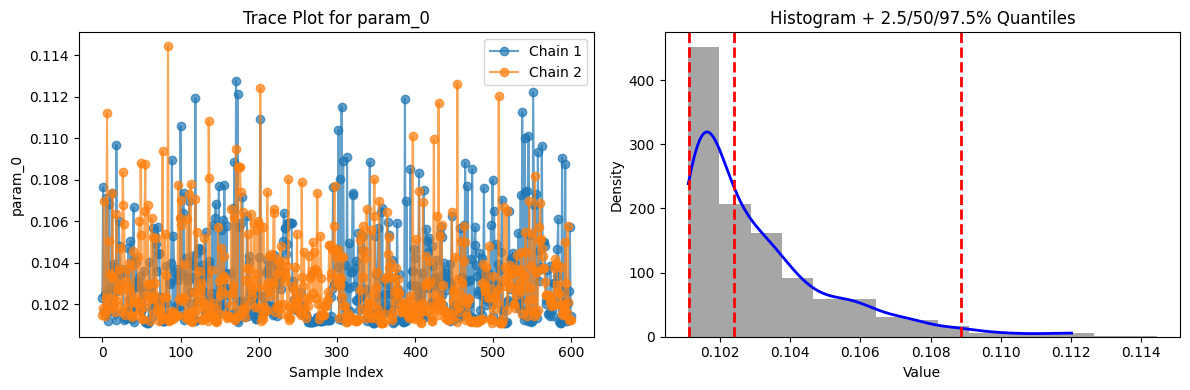

<Figure size 600x400 with 0 Axes>

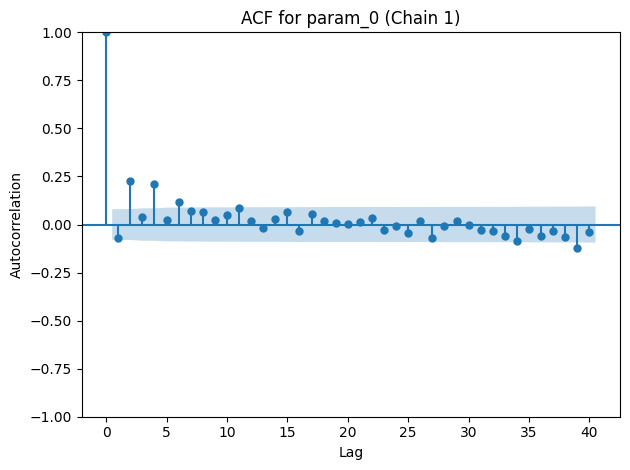

param_1: R-hat = 0.999, split R-hat = 0.999, ESS = 894.1


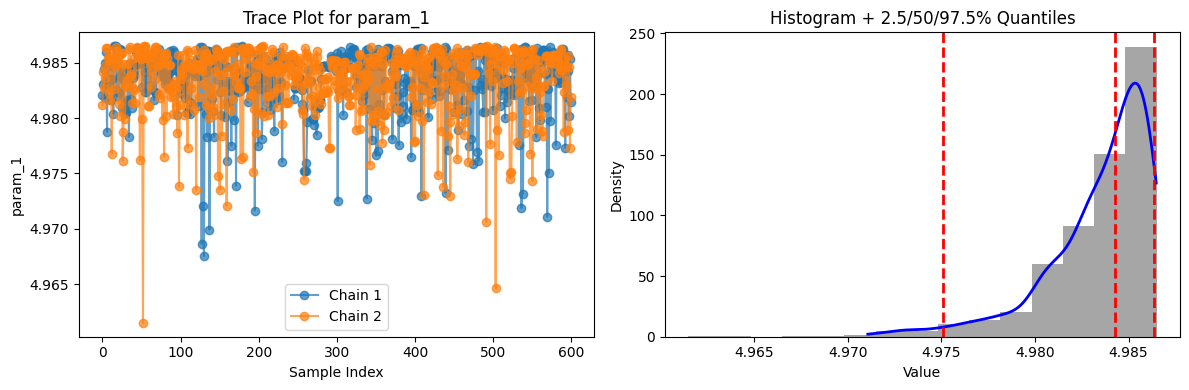

<Figure size 600x400 with 0 Axes>

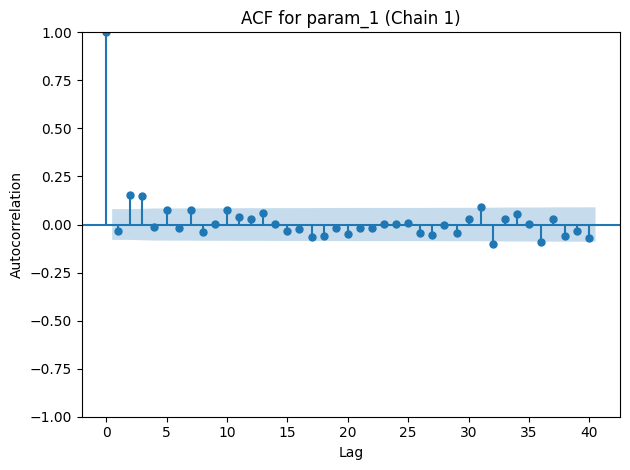

param_2: R-hat = 1.003, split R-hat = 1.010, ESS = 145.6


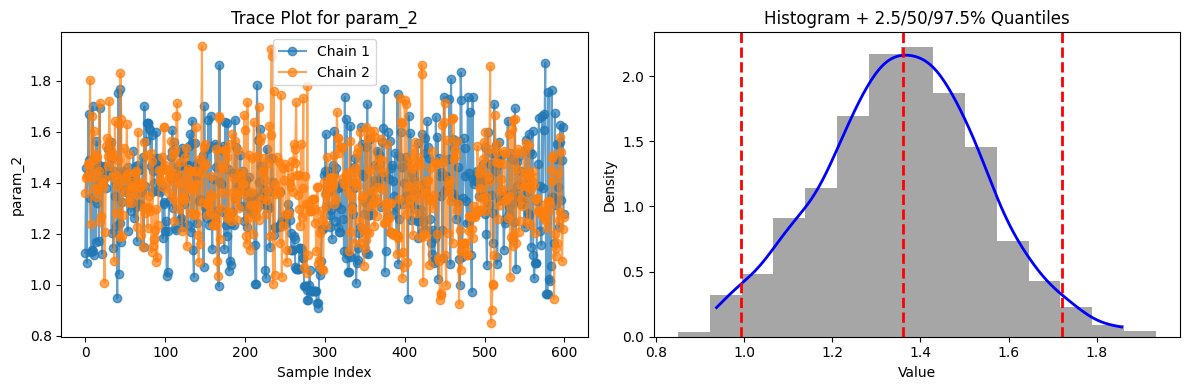

<Figure size 600x400 with 0 Axes>

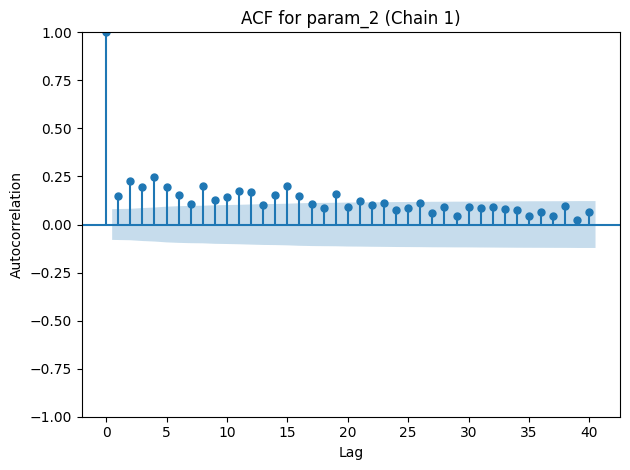

param_3: R-hat = 1.003, split R-hat = 1.002, ESS = 421.4


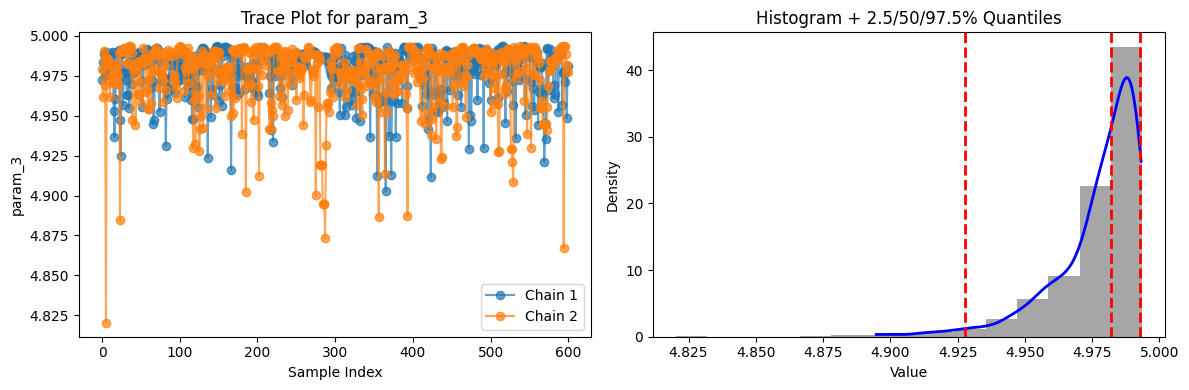

<Figure size 600x400 with 0 Axes>

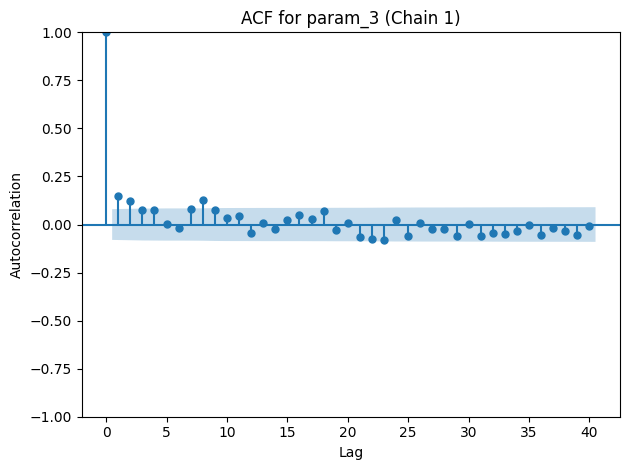

param_4: R-hat = 0.999, split R-hat = 1.075, ESS = 51.4


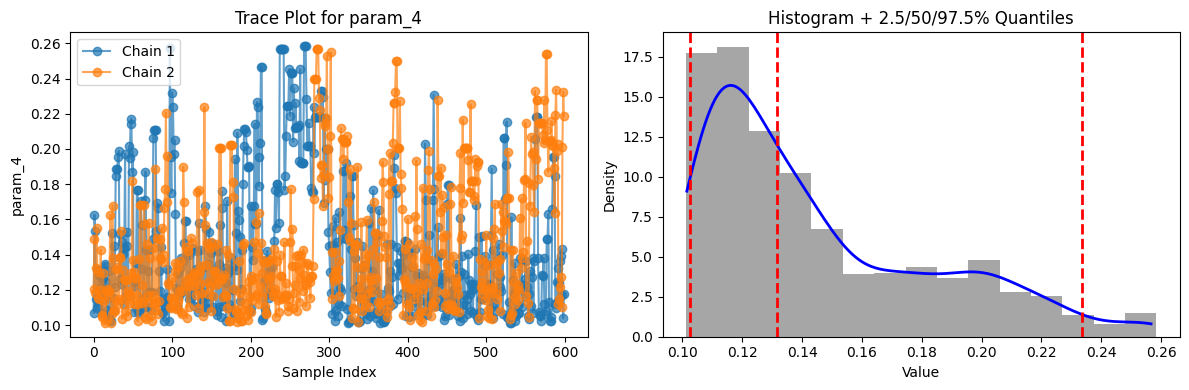

<Figure size 600x400 with 0 Axes>

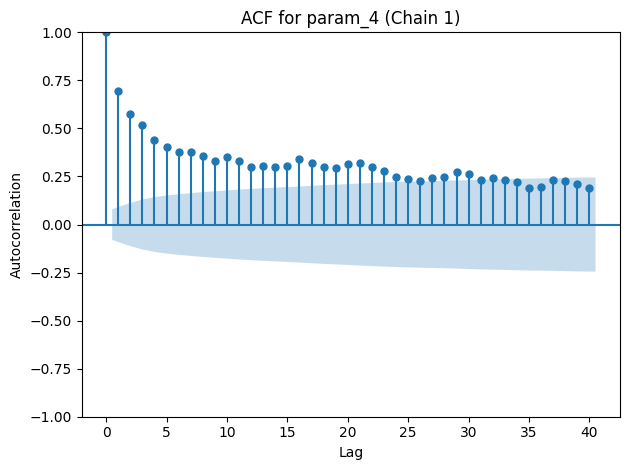

param_5: R-hat = 1.000, split R-hat = 1.077, ESS = 49.6


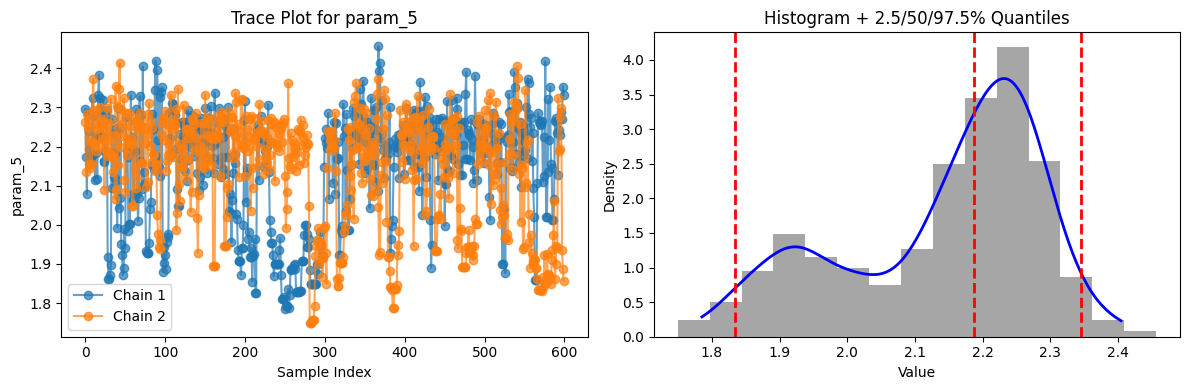

<Figure size 600x400 with 0 Axes>

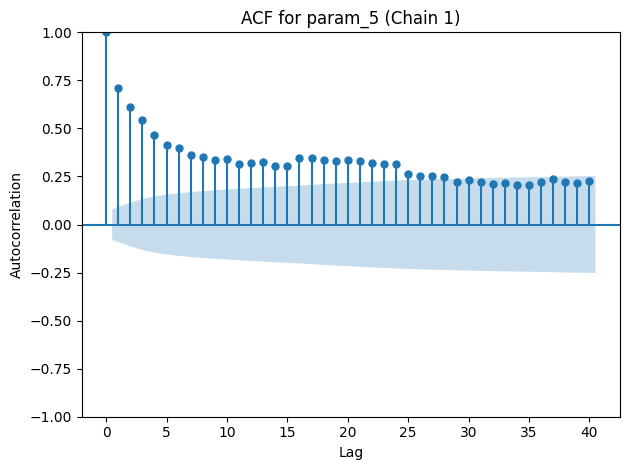

param_6: R-hat = 1.001, split R-hat = 1.000, ESS = 522.2


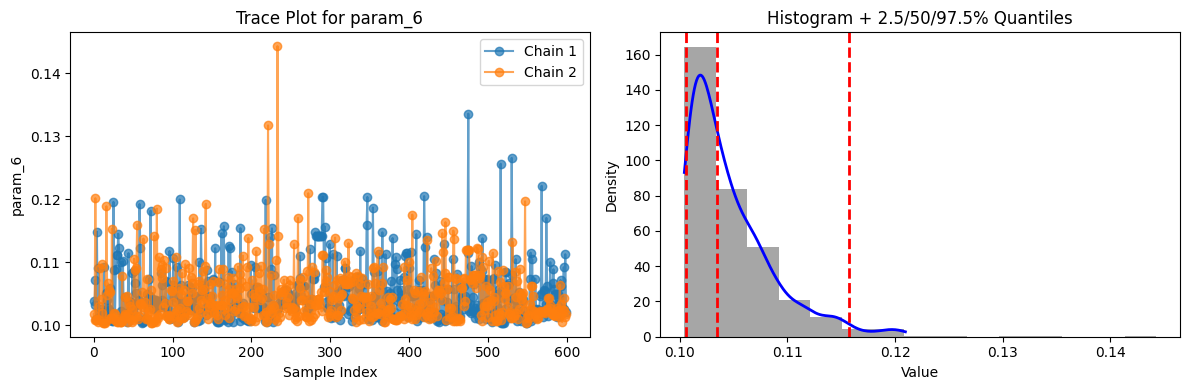

<Figure size 600x400 with 0 Axes>

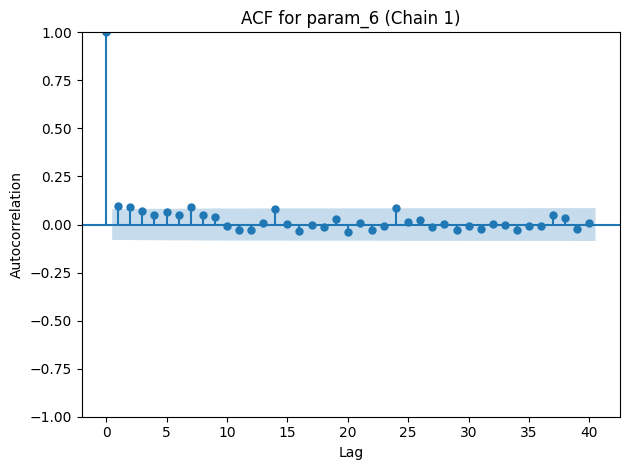

param_7: R-hat = 1.003, split R-hat = 1.004, ESS = 405.1


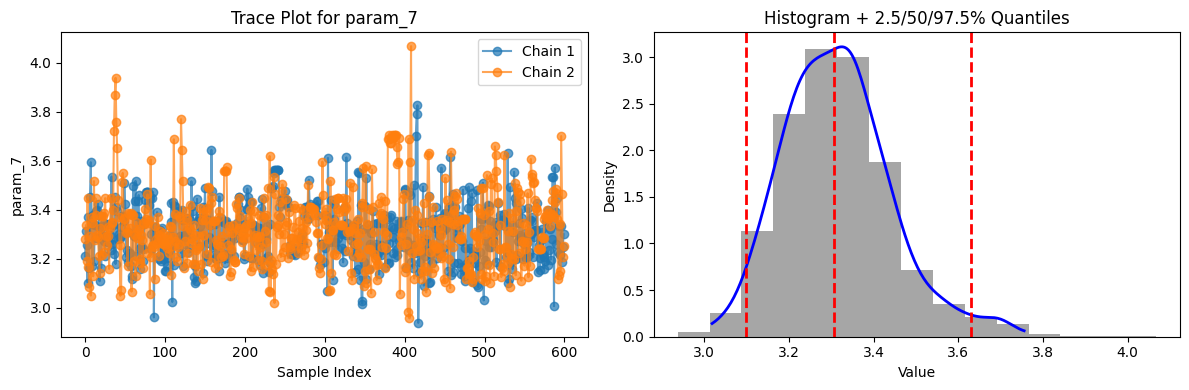

<Figure size 600x400 with 0 Axes>

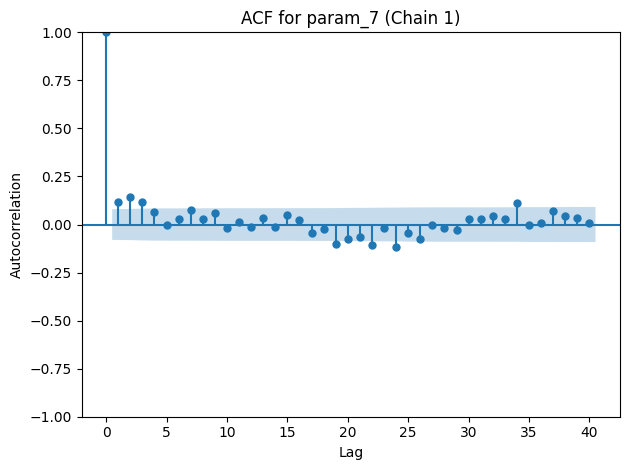

param_8: R-hat = 1.000, split R-hat = 0.999, ESS = 603.7


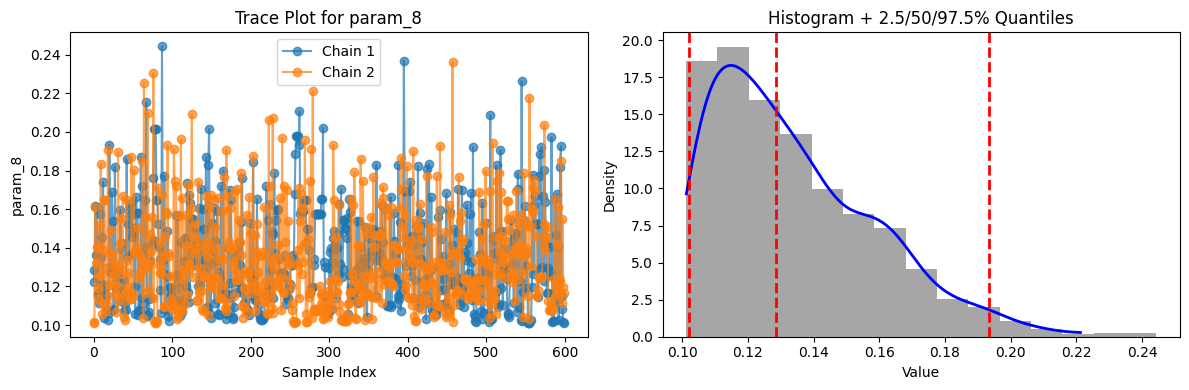

<Figure size 600x400 with 0 Axes>

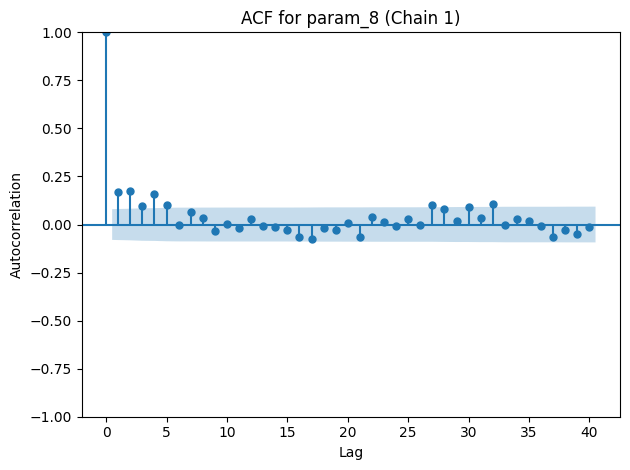

param_9: R-hat = 1.004, split R-hat = 1.003, ESS = 324.8


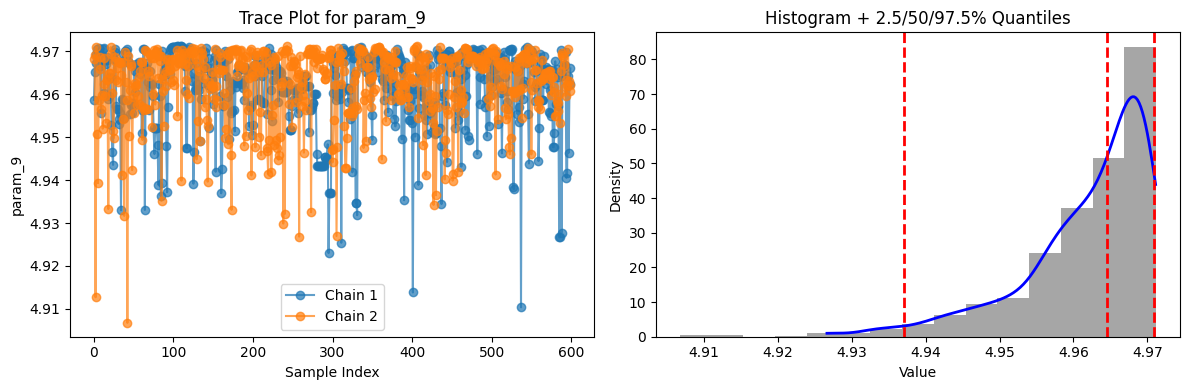

<Figure size 600x400 with 0 Axes>

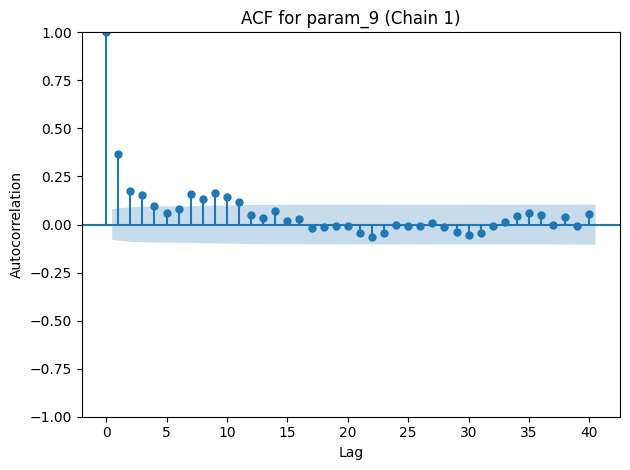

In [31]:
single_chain_samples = posterior_samples_Uniform  # dict: param -> Tensor[n_samples]

# 将每条参数的样本拆成两半
def split_chain(chain_tensor):
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]

# 整理成 mcmc_samples：param -> Tensor[2, n_half]
mcmc_samples = {}
for param, samples in single_chain_samples.items():
    chain_a, chain_b = split_chain(samples)
    # 如果原链长度是奇数，可以选择丢弃最后一个样本或做其他处理
    mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)




# 诊断和可视化
for param, samples_chains in mcmc_samples.items():

    
    # 计算诊断量
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    print(f"{param}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
    
    # 绘制 Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)

    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # 绘制 Histogram + Quantiles
    plt.subplot(1, 2, 2)
    all_samps = samples_chains.reshape(-1).cpu().numpy()

    xmin, xmax = np.percentile(all_samps, [0.5, 99.5])

    plt.hist(all_samps, bins=15, density=True, alpha=0.7, color='gray')

    kde = gaussian_kde(all_samps)
    x_grid = np.linspace(xmin, xmax, 200)
    # plt.plot(x_grid, kde(x_grid), color='blue', linewidth=2, label="KDE")
    plt.plot(x_grid, kde(x_grid), color='blue', linewidth=2)

    qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    
    # plt.xlim(0.1, 5)

    plt.title(f"Histogram + 2.5/50/97.5% Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()
    
    # 绘制 ACF（仅第一“伪链”）
    plt.figure(figsize=(6,4))
    plot_acf(samples_chains[0].cpu().numpy(), lags=40)
    plt.title(f"ACF for {param} (Chain 1)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

In [32]:
test_r = [(0.1), 
          (4.986), 
          (4.985), 
          (0.115), 
          (0.10), 
          (2.6),
          (0.1), 
          (2.9), 
          (0.11), 
          (4.96)]

Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cuda().unsqueeze(0)).cpu().detach().numpy()

array([ 5.7090533e-01, -4.4896016e+00, -1.4691168e-01, -1.2056507e+00,
        1.7772528e+00, -4.6140933e-01,  9.8701227e-01,  3.7059081e-01,
       -7.4105859e-02, -2.3390107e-01,  3.8449988e-01, -6.6894799e-02,
        5.7368219e-02, -1.0718040e-01,  2.5873029e-01,  1.7534278e-01,
        3.8824677e-03, -6.9306850e-02,  1.3002574e-01, -8.6078644e-02,
       -3.2290488e-02], dtype=float32)

In [40]:
test_r = [(0.11), 
          (1.9), 
          (1.4), 
          (2.9), 
          (0.10), 
          (2.2),
          (0.1), 
          (3.3), 
          (0.11), 
          (2.9)]

Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cuda().unsqueeze(0)).cpu().detach().numpy()

array([ 1.0625547 , -6.834503  ,  0.33086163,  0.4184469 ,  1.2505057 ,
       -2.067125  ,  1.1871718 ,  0.8820444 , -0.1729213 , -0.12187952,
        0.23155358, -0.08835965, -0.03823277, -0.18838692,  0.02505422,
        0.13118395,  0.05327451, -0.11107273,  0.16550905, -0.03370042,
       -0.14385784], dtype=float32)

In [33]:
input_point

tensor([[ 0.8210, -5.0154, -0.3457, -1.0297,  1.6772, -1.4408,  0.5200,  1.1670,
          0.4312,  0.7409,  1.0471, -0.5937,  0.9274, -0.7857, -0.6361,  0.1623,
          0.7058, -0.0390,  0.1800, -0.2805,  0.2313]])

# End